In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import tensorflow as tf
import statistics as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.compat.v1 import reset_default_graph
from tensorflow.keras import backend as K
from math import sqrt
from numpy.random import seed

Using TensorFlow backend.


In [0]:
# ensure repeatability
np.random.seed(23)
tf.random.set_seed(23)

In [0]:
data = pd.read_csv("ML_data.csv", sep="|")
pd.set_option("display.max_columns", None)

In [0]:
# add in various functions to x
x = data.iloc[:, 10:15]
y = data.iloc[:, 6:10]
new_data = x.copy()
with np.errstate(divide='ignore', over='ignore'):
    new_data[x.columns + '^2']=(data[x.columns])**2
    new_data[x.columns + '^3']=(data[x.columns])**3
    new_data[x.columns + 'sqrt']=abs(data[x.columns])**(1/2)
    new_data[x.columns + 'cbrt']=abs(data[x.columns])**(1/3)
    new_data[x.columns + 'e^x']=np.exp(data[x.columns])
    new_data[x.columns + 'e^x-1']=np.expm1(data[x.columns])
    new_data[x.columns + '2^x']=np.exp2(data[x.columns])
    new_data[x.columns + 'lnx']=np.log(abs(data[x.columns]))
    new_data[x.columns + 'log10x']=np.log10(abs(data[x.columns]))
    new_data[x.columns + 'log2x']=np.log2(abs(data[x.columns]))
    new_data[x.columns + 'ln(1+x)']=np.log1p(abs(data[x.columns]))

In [5]:
new_data=new_data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
frames= [new_data, data.iloc[:, 15:52]]
func_data=pd.concat(frames, axis=1)
func_data

,Z_A,Z_B,PBE_delta_H,PBE_latt_const,PBE_gap,Z_A^2,Z_B^2,PBE_delta_H^2,PBE_latt_const^2,PBE_gap^2,Z_A^3,Z_B^3,PBE_delta_H^3,PBE_latt_const^3,PBE_gap^3,Z_Asqrt,Z_Bsqrt,PBE_delta_Hsqrt,PBE_latt_constsqrt,PBE_gapsqrt,Z_Acbrt,Z_Bcbrt,PBE_delta_Hcbrt,PBE_latt_constcbrt,PBE_gapcbrt,Z_Ae^x,Z_Be^x,PBE_delta_He^x,PBE_latt_conste^x,PBE_gape^x,Z_Ae^x-1,Z_Be^x-1,PBE_delta_He^x-1,PBE_latt_conste^x-1,PBE_gape^x-1,Z_A2^x,Z_B2^x,PBE_delta_H2^x,PBE_latt_const2^x,PBE_gap2^x,Z_Alnx,Z_Blnx,PBE_latt_constlnx,Z_Alog10x,Z_Blog10x,PBE_latt_constlog10x,Z_Alog2x,Z_Blog2x,PBE_latt_constlog2x,Z_Aln(1+x),Z_Bln(1+x),PBE_delta_Hln(1+x),PBE_latt_constln(1+x),PBE_gapln(1+x),Eps_elec,Eps_ion,CM1,CM2,CM3,CM4,CM5,CM6,CM7,CM8,Ion_rad,BP,MP,Density,At_wt,ICSD_vol,Cov_rad,Ion_Energy,At_rad_1,Elec_Aff,At_rad_2,At_vol,Mend_num,Ion_pot_1,Ion_pot_2,Thermal_expn,Sp_heat_cap,Therm_cond,Elec_cond,Heat_fusion,Heat_vap,Electronegativity,At_num,Period,Group,Valence,Ox_state
0,14,6,-0.42,4.25,1.27,196,36,0.1764,18.0625,1.6129,2744,216,-0.074088,76.765625,2.048383,3.741657,2.449490,0.648074,2.061553,1.126943,2.410142,1.817121,0.748887,1.619806,1.082932,1.202604e+06,403.428793,0.657047,70.105412,3.560853,1.202603e+06,402.428793,-0.342953,69.105412,2.560853,1.638400e+04,64.0,0.747425,19.027314,2.411616,2.639057,1.791759,1.446919,1.146128,0.778151,0.628389,3.807355,2.584963,2.087463,2.708050,1.945910,0.350657,1.658228,0.819780,18.06,2.27,373.01,373.01,373.01,373.01,138.44,138.44,138.44,79.93,0.80,2350.0,429.78,7.31,114.82,26.1,1.44,558.3,1.66,29.0,2.00,15.70,75,5.79,18.87,32.1,0.23,81.60,3.4,3.26,226.34,1.78,49,5,13,3,3
1,14,6,-0.42,4.25,1.27,196,36,0.1764,18.0625,1.6129,2744,216,-0.074088,76.765625,2.048383,3.741657,2.449490,0.648074,2.061553,1.126943,2.410142,1.817121,0.748887,1.619806,1.082932,1.202604e+06,403.428793,0.657047,70.105412,3.560853,1.202603e+06,402.428793,-0.342953,69.105412,2.560853,1.638400e+04,64.0,0.747425,19.027314,2.411616,2.639057,1.791759,1.446919,1.146128,0.778151,0.628389,3.807355,2.584963,2.087463,2.708050,1.945910,0.350657,1.658228,0.819780,18.06,2.27,375.78,375.78,375.78,216.96,185.96,185.96,185.96,185.96,1.16,3737.0,1191.00,6.15,138.91,37.4,1.25,538.1,1.88,50.0,2.74,20.73,13,5.58,11.06,5.2,0.19,13.50,1.9,11.30,399.57,1.10,57,6,3,3,3
2,14,6,-0.42,4.25,1.27,196,36,0.1764,18.0625,1.6129,2744,216,-0.074088,76.765625,2.048383,3.741657,2.449490,0.648074,2.061553,1.126943,2.410142,1.817121,0.748887,1.619806,1.082932,1.202604e+06,403.428793,0.657047,70.105412,3.560853,1.202603e+06,402.428793,-0.342953,69.105412,2.560853,1.638400e+04,64.0,0.747425,19.027314,2.411616,2.639057,1.791759,1.446919,1.146128,0.778151,0.628389,3.807355,2.584963,2.087463,2.708050,1.945910,0.350657,1.658228,0.819780,18.06,2.27,152.25,238.53,238.53,238.53,102.23,102.23,102.23,65.25,0.74,1180.0,692.73,7.13,65.39,15.1,1.25,906.4,1.33,0.0,1.53,9.20,69,9.39,17.96,30.2,0.39,116.00,16.9,7.38,115.30,1.65,30,4,12,2,2
3,14,6,-0.42,4.25,1.27,196,36,0.1764,18.0625,1.6129,2744,216,-0.074088,76.765625,2.048383,3.741657,2.449490,0.648074,2.061553,1.126943,2.410142,1.817121,0.748887,1.619806,1.082932,1.202604e+06,403.428793,0.657047,70.105412,3.560853,1.202603e+06,402.428793,-0.342953,69.105412,2.560853,1.638400e+04,64.0,0.747425,19.027314,2.411616,2.639057,1.791759,1.446919,1.146128,0.778151,0.628389,3.807355,2.584963,2.087463,2.708050,1.945910,0.350657,1.658228,0.819780,18.06,2.27,85.70,85.70,85.70,49.48,42.41,42.41,42.41,42.41,0.54,2740.0,933.50,2.70,26.98,16.6,1.18,577.6,1.43,45.0,1.62,10.00,73,5.99,18.83,23.1,0.90,237.00,37.7,10.70,290.80,1.61,13,3,13,3,3
4,14,6,-0.42,4.25,1.27,196,36,0.1764,18.0625,1.6129,2744,216,-0.074088,76.765625,2.048383,3.741657,2.449490,0.648074,2.061553,1.126943,2.410142,1.817121,0.748887,1.619806,1.082932,1.202604e+06,403.428793,0.657047,70.105412,3.560853,1.202603e+06,402.428793,-0.342953,69.105412,2.560853,1.638400e+04,64.0,0.747425,19.027314,2.411616,2.639057,1.791759,1.446919,1.146128,0.778151,0.628389,3.807355,2.584963,2.087463,2.708050,1.945910,0.350657,1.658228,0.

In [0]:
############ DATA PRE-PROCESSING ############ 

# separate categorical and continuous data 
categorical=pd.DataFrame()
continuous=pd.DataFrame()

for index in func_data.columns:
    if(func_data[index].dtypes == "int"):
        categorical[index]=func_data[index]
    elif(func_data[index].dtypes == "float"):
        continuous[index]=func_data[index]
    else:
        pass

# one hot encode categorical data
onehotencoder = OneHotEncoder()
categorical = onehotencoder.fit_transform(categorical).toarray()

# standardize continuous data
scaler = StandardScaler()
continuous = scaler.fit_transform(continuous)

# re-combine categorical and continuous data
x = np.concatenate((continuous, categorical), axis=1)

# extract y data and standardize (DFT predicted / output)
y = scaler.fit_transform(y)

# split training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=23)

# input and output dimension
in_dim = x.shape[1]
out_dim = y.shape[1]

In [0]:
# construct model

def neural_network(epochs=150, batch_size=70, hidden_layers=4, learning_rate=0.0005, adam_decay=0):
    # Create and add layers to model
    model = Sequential()
    model.add(Dense(out_dim*308, input_dim=in_dim, activation='relu',
              kernel_regularizer=l2(.05)))
    model.add(Dropout(0.01))
    model.add(Dense(out_dim*308, activation='relu', ))
    model.add(Dense(out_dim*154, activation='relu'))
    model.add(Dropout(0.01))
    model.add(Dense(out_dim*154, activation='relu'))
    model.add(Dense(out_dim))

    # configure optimizer & compile model
    opt = Adam(lr=learning_rate, decay=adam_decay)   ### need editing later (learning_rate, adam_decay)
    model.compile(loss="mse", optimizer=opt)

    # summarize model
    print(model.summary())
    
    # train model
    prediction = model.fit(x_train, y_train,
                          validation_data=(x_test, y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1)
    
    return (model, prediction)

In [0]:
# Parameters
epochs=1000
batch_size=20
learning_rate=2.3e-3
adam_decay=1e-2

hidden_layers=4  #not used

In [9]:
model, prediction = neural_network(epochs=epochs, batch_size=batch_size, hidden_layers=hidden_layers,
                                   learning_rate=learning_rate, adam_decay=adam_decay)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1232)              380688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1232)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1232)              1519056   
_________________________________________________________________
dense_3 (Dense)              (None, 616)               759528    
_________________________________________________________________
dropout_2 (Dropout)          (None, 616)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 616)               380072    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [10]:
pred_test = model.predict(x_test)
RMSE_test = (stats.mean([sqrt(mean_squared_error(y_test[:,0], pred_test[:,0])), 
                        sqrt(mean_squared_error(y_test[:,1], pred_test[:,1])),  
                        sqrt(mean_squared_error(y_test[:,2], pred_test[:,2])),
                        sqrt(mean_squared_error(y_test[:,3], pred_test[:,3]))
                        ])
            )
print(RMSE_test)

0.3277369942404723


In [11]:
low_epoch = (np.argmin(prediction.history["val_loss"]) + 1)
low_val_loss = np.amin(prediction.history["val_loss"])
print("Lowest Val_loss: %.5f at %s epochs" % (low_val_loss, low_epoch))

Lowest Val_loss: 0.11430 at 858 epochs


In [12]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
pred_overall = model.predict(x)

print("RMSE Training/Testing (eV)")
print("(+2/+1): %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,0], pred_train[:,0])),
     (sqrt(mean_squared_error(y_test[:,0], pred_test[:,0])))))
print("(+1/0): %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,1], pred_train[:,1])),
     (sqrt(mean_squared_error(y_test[:,1], pred_test[:,1])))))
print("(0/-1): %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,2], pred_train[:,2])),
     (sqrt(mean_squared_error(y_test[:,2], pred_test[:,2])))))
print("(-1/-2): %.4f / %.4f" % (sqrt(mean_squared_error(y_train[:,3], pred_train[:,3])),
     (sqrt(mean_squared_error(y_test[:,3], pred_test[:,3])))))

RMSE Training/Testing (eV)
(+2/+1): 0.0864 / 0.4608
(+1/0): 0.0940 / 0.3318
(0/-1): 0.0791 / 0.2869
(-1/-2): 0.0688 / 0.2315


(-2.942757701873779, 3.737232780456545)

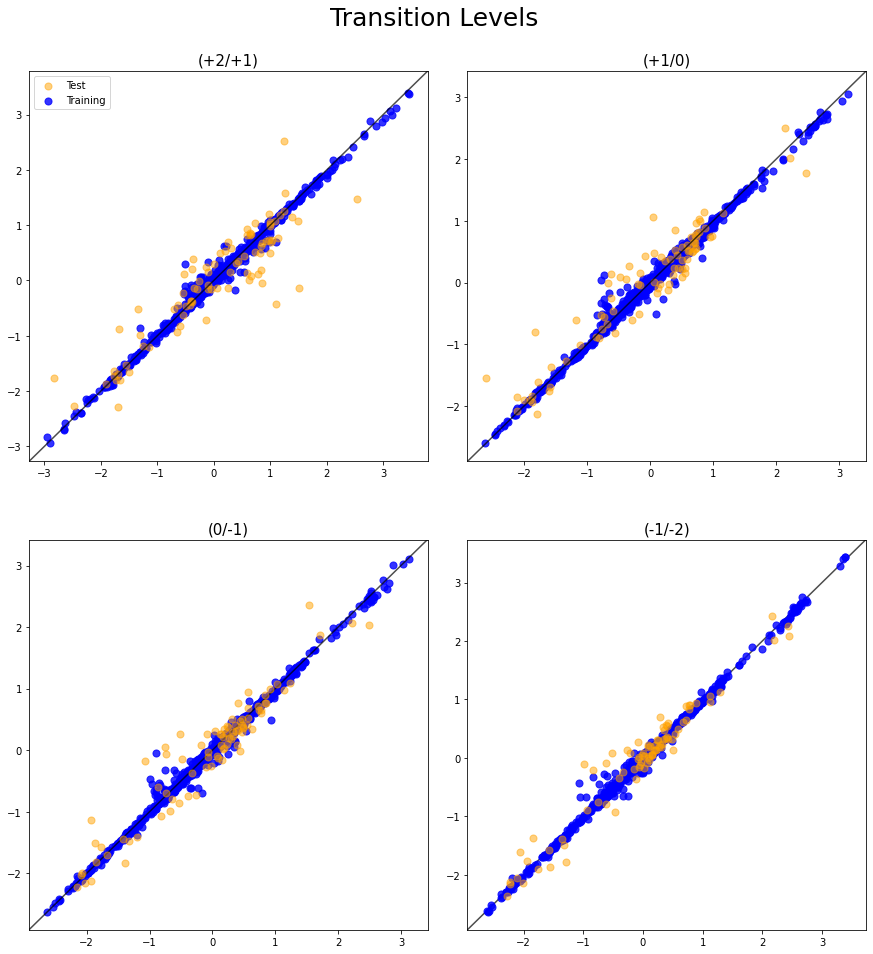

In [13]:
# plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=.2, wspace = 0.1, top=.92)
fig.suptitle("Transition Levels", fontsize=25, va='top')

subtitle_size=15
test_alpha = 0.5
train_alpha = 0.8
scatter_size = 50
test_color = "#ffa200"  
train_color = "blue"

#############################################################
ax[0,0].set_title("(+2/+1)", fontsize=subtitle_size)
ax[0,0].scatter(y_test[:,0], pred_test[:,0], label="Test", color=test_color, alpha=test_alpha, zorder=2, s=scatter_size)
ax[0,0].scatter(y_train[:,0], pred_train[:,0], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[0,0].get_xlim(), ax[0,0].get_ylim()]),
        np.max([ax[0,0].get_xlim(), ax[0,0].get_ylim()])]
ax[0,0].plot(lims, lims, color="black", zorder=3, alpha=0.7)
ax[0,0].set_xlim(lims)
ax[0,0].set_ylim(lims)
ax[0,0].legend()

#############################################################
ax[0,1].set_title("(+1/0)", fontsize=subtitle_size)
ax[0,1].scatter(y_test[:,1], pred_test[:,1], label="Test", color=test_color, alpha=test_alpha, zorder=2, s=scatter_size)
ax[0,1].scatter(y_train[:,1], pred_train[:,1], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[0,1].get_xlim(), ax[0,1].get_ylim()]),
        np.max([ax[0,1].get_xlim(), ax[0,1].get_ylim()])]
ax[0,1].plot(lims, lims, color="black", zorder=3, alpha=0.7)
ax[0,1].set_xlim(lims)
ax[0,1].set_ylim(lims)

#############################################################
ax[1,0].set_title("(0/-1)", fontsize=subtitle_size)
ax[1,0].scatter(y_test[:,2], pred_test[:,2], label="Test", color=test_color, alpha=test_alpha, zorder=2, s=scatter_size)
ax[1,0].scatter(y_train[:,2], pred_train[:,2], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[1,0].get_xlim(), ax[1,0].get_ylim()]),
        np.max([ax[1,0].get_xlim(), ax[1,0].get_ylim()])]
ax[1,0].plot(lims, lims, color="black", zorder=1, alpha=0.7)
ax[1,0].set_xlim(lims)
ax[1,0].set_ylim(lims)

#############################################################
ax[1,1].set_title("(-1/-2)", fontsize=subtitle_size)
ax[1,1].scatter(y_test[:,3], pred_test[:,3], label="Test", color=test_color, alpha=test_alpha, zorder=2, s=scatter_size)
ax[1,1].scatter(y_train[:,3], pred_train[:,3], label="Training", color=train_color, alpha=train_alpha,
                zorder=1, s=scatter_size)
lims = [np.min([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
        np.max([ax[1,1].get_xlim(), ax[1,1].get_ylim()])]
ax[1,1].plot(lims, lims, color="black", zorder=0, alpha=0.7)
ax[1,1].set_xlim(lims)
ax[1,1].set_ylim(lims)

Text(0.5, 1.0, 'Training/Validation Loss')

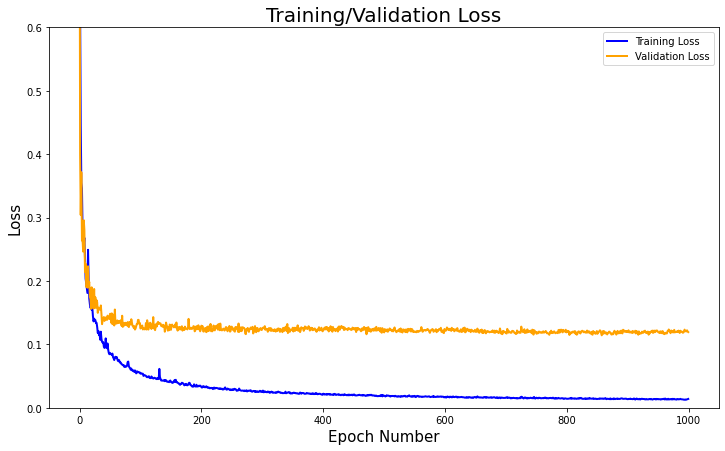

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
x_plot = np.arange(0, epochs)
ax.plot(x_plot, prediction.history["loss"], label="Training Loss", color=train_color, lw=2)
ax.plot(x_plot, prediction.history["val_loss"], label="Validation Loss", color=test_color, lw=2)
ax.legend(loc="upper right")
ax.set_xlabel("Epoch Number", fontsize=15)
ax.set_ylabel("Loss", fontsize=15)
ax.set_ylim(0, .6)
ax.set_title('Training/Validation Loss', fontsize=20)